# Heart Disease Prediction - ML Final Project

## 1. Problem Definition

The goal of this project is to build a machine learning model to predict the presence of heart disease in patients based on various medical and demographic features. This is a binary classification problem where the aim is to predict whether a patient has heart disease (1) or not (0).

### Dataset Overview
I will be using the Heart Disease dataset from Kaggle, which contains medical records with the following key characteristics:
- **Target Variable**: Presence of heart disease (0 = no disease, 1 = disease)
- **Features**: Various medical measurements and patient demographics
- **Problem Type**: Binary Classification
- **Evaluation Metrics**: Accuracy, Precision, Recall, F1-Score, AUC-ROC
- **Dataset Source:** : [Heart Disease Dataset](https://www.kaggle.com/datasets/johnsmith88/heart-disease-dataset)

### Project Steps
1. **Problem Definition**
2. **Data Loading and Inspection**
3. **EDA and Visualization**
4. **Data Preprocessing**
5. **Model Training**
6. **Evaluation**
7. **Discussion & Conclusion**

### Success Criteria
- Achieve high accuracy in predicting heart disease presence
- Minimize false negatives (missing actual heart disease cases)
- Create an interpretable model for medical decision support

## 2. Data Loading and Inspection

In [1]:
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve

### Load the downloaded dataset in ./data

In [2]:
df = pd.read_csv("data/heart.csv")

## 3. EDA and Visualization

### Preview rows
Dataset: Heart Disease targets: 0 = no disease, 1 = disease.

In [3]:
print(f"Shape: {df.shape[0]} rows × {df.shape[1]} columns")
df.head()

Shape: 1025 rows × 14 columns


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0


### Inspect data types and missing values
Checking column types and null counts ensures features are correctly interpreted

In [4]:
df.info()
df.dtypes.value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1025 entries, 0 to 1024
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1025 non-null   int64  
 1   sex       1025 non-null   int64  
 2   cp        1025 non-null   int64  
 3   trestbps  1025 non-null   int64  
 4   chol      1025 non-null   int64  
 5   fbs       1025 non-null   int64  
 6   restecg   1025 non-null   int64  
 7   thalach   1025 non-null   int64  
 8   exang     1025 non-null   int64  
 9   oldpeak   1025 non-null   float64
 10  slope     1025 non-null   int64  
 11  ca        1025 non-null   int64  
 12  thal      1025 non-null   int64  
 13  target    1025 non-null   int64  
dtypes: float64(1), int64(13)
memory usage: 112.2 KB


int64      13
float64     1
Name: count, dtype: int64

### Summary Statistics and Data Integrity Check
Review basic descriptive statistics, confirm no missing values, and ensure there are no duplicate rows before further analysis.

In [5]:
# Summary statistics
df.describe()

# Check for missing values and duplicates
nulls = df.isnull().sum()

if nulls.sum():
    print("Missing Values:", nulls[nulls > 0])
else:
    print("Missing Values: None found")

Missing Values: None found


### Distribution of Continuous Variables
Visualizing the spread of continuous features helps identify skewness, outliers, and potential transformations before comparing against the target variable.

Continuous variables include:

- "**age** – patient age"

- "**trestbps** – resting blood pressure"

- "**chol** – serum cholesterol"

- "**thalach** – maximum heart rate achieved"

- "**oldpeak** – ST depression induced by exercise relative to rest"

In [6]:
# we will use these later
cont_cols = ['age','trestbps','chol','thalach','oldpeak']
cat_cols  = ['sex','cp','fbs','restecg','exang','slope','ca','thal']

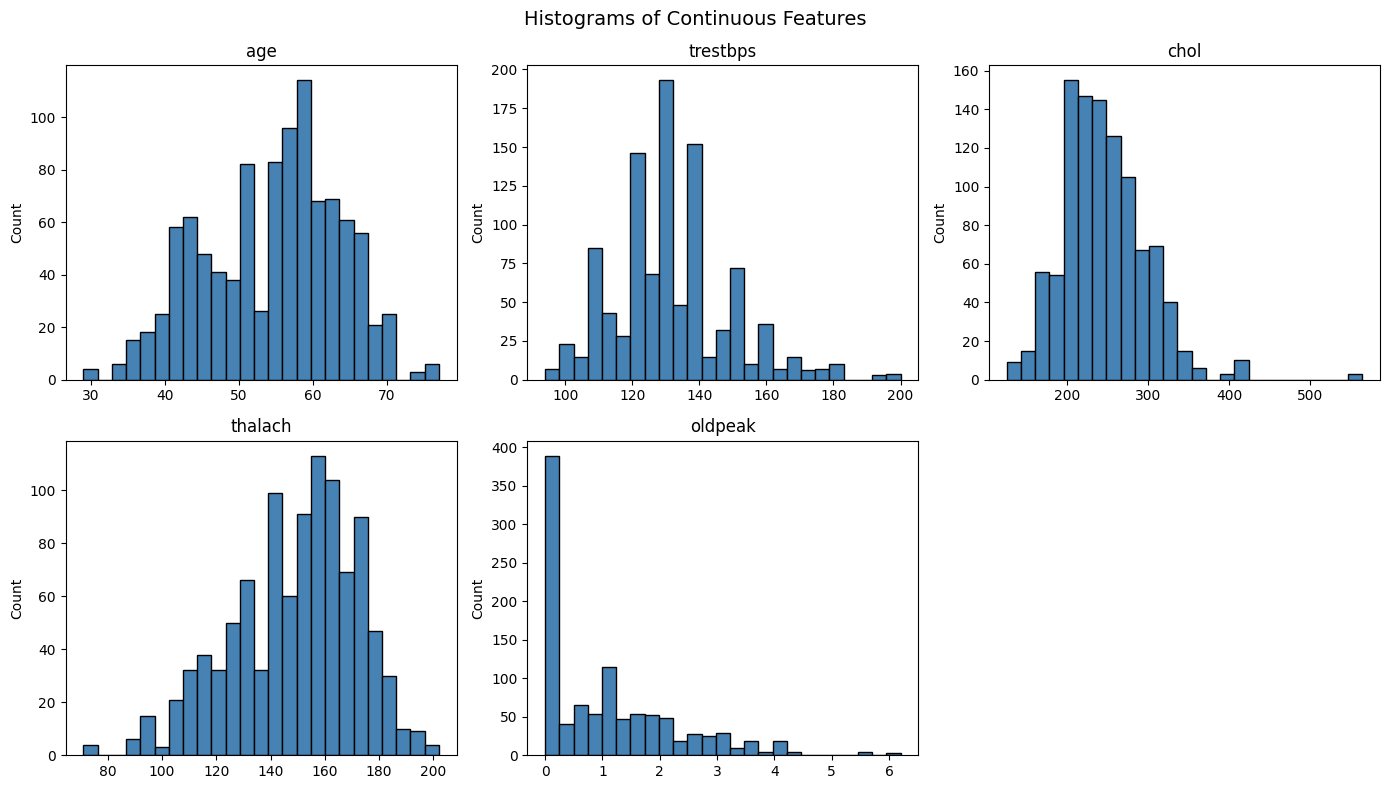

In [7]:
fig, axes = plt.subplots(2, 3, figsize=(14, 8))
axes = axes.flatten()

for i, col in enumerate(cont_cols):
    axes[i].hist(df[col], bins=25, edgecolor='black', color='steelblue')
    axes[i].set_title(col)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('Count')

# Remove empty subplot if grid > number of features
for j in range(len(cont_cols), len(axes)):
    fig.delaxes(axes[j])

plt.suptitle('Histograms of Continuous Features', fontsize=14)
plt.tight_layout()
plt.show()

Most continuous features show right-skewed distributions. This might indicate outliers. Scaling might be helpful before training.

### Detect Outliers in Continuous Features
Boxplots and IQR statistics are used to identify potential outliers in continuous variables (age, trestbps, chol, thalach, oldpeak).

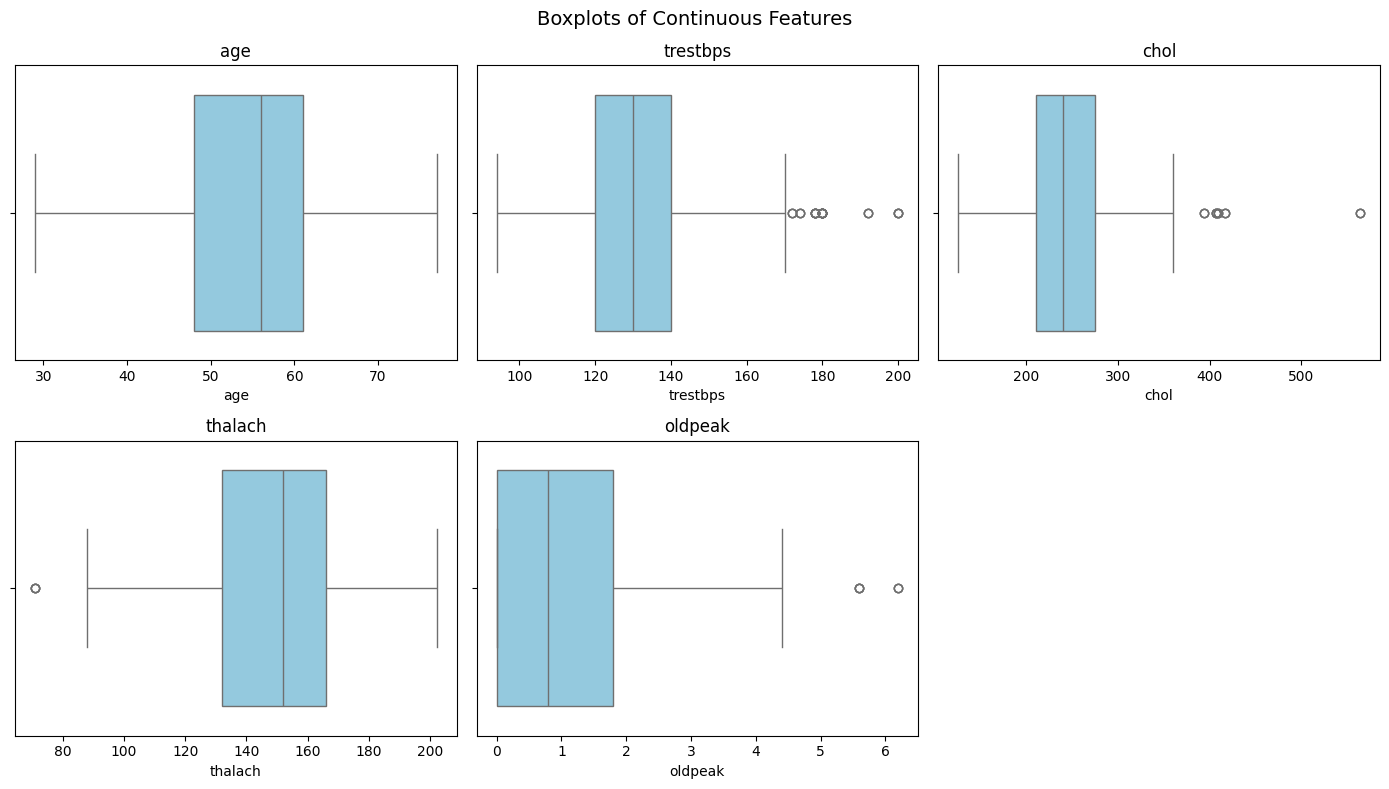

,Q1,Q3,IQR,Lower,Upper,Outliers
age,48.0,61.0,13.0,28.5,80.5,0.0
trestbps,120.0,140.0,20.0,90.0,170.0,30.0
chol,211.0,275.0,64.0,115.0,371.0,16.0
thalach,132.0,166.0,34.0,81.0,217.0,4.0
oldpeak,0.0,1.8,1.8,-2.7,4.5,7.0


In [8]:
# Boxplots for continuous features
fig, axes = plt.subplots(2, 3, figsize=(14, 8))
axes = axes.flatten()

for i, col in enumerate(cont_cols):
    sns.boxplot(x=df[col], ax=axes[i], color='skyblue')
    axes[i].set_title(col)

for j in range(len(cont_cols), len(axes)):
    fig.delaxes(axes[j])

plt.suptitle("Boxplots of Continuous Features", fontsize=14)
plt.tight_layout()
plt.show()

def iqr_bounds(s):
    q1, q3 = s.quantile([0.25, 0.75])
    iqr = q3 - q1
    lower, upper = q1 - 1.5 * iqr, q3 + 1.5 * iqr
    outliers = ((s < lower) | (s > upper)).sum()
    return pd.Series({'Q1': q1, 'Q3': q3, 'IQR': iqr, 'Lower': lower, 'Upper': upper, 'Outliers': outliers})

iqr_table = df[cont_cols].apply(iqr_bounds).T
iqr_table

Chol, oldpeak, and trestbps show several right-tail outliers, suggesting a few patients with extremely high cholesterol or ST depression values. These will be kept for now because they might represent meaningful data rather then data errors.

### Generate a correlation matrix (Post One-Hot Encoding)
Examining feature correlations with the target helps identify which health indicators are most predictive of heart disease.

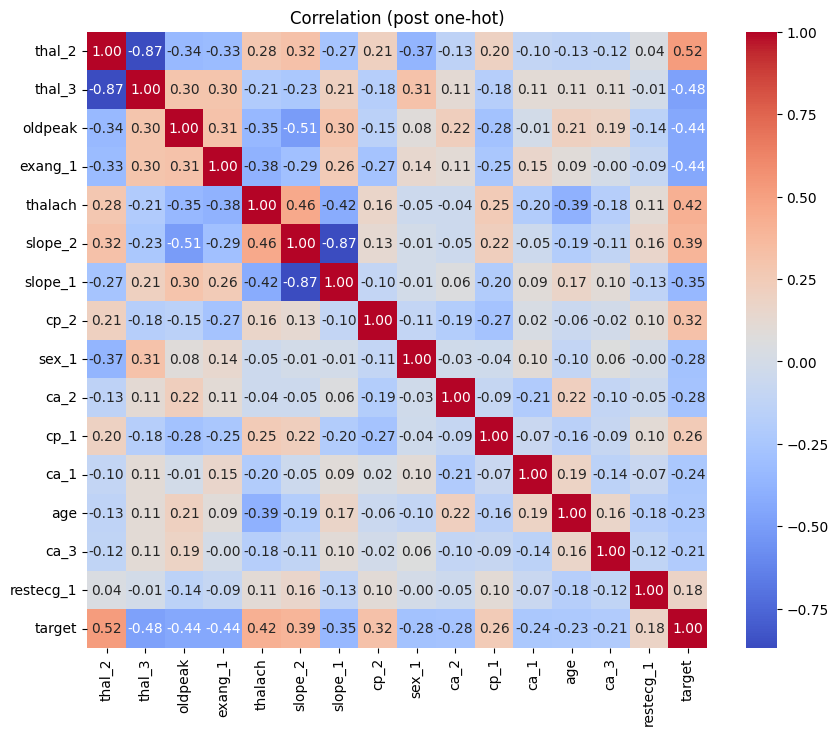

In [9]:
# Compute correlations with target and visualize top correlated features
df_enc = pd.get_dummies(df, columns=cat_cols, drop_first=True)

# Correlation of all features with target
corr_to_target = df_enc.corr(numeric_only=True)['target'].sort_values(ascending=False)
corr_to_target.head(15)
corr_to_target.tail(15)

# Select top correlated features for visualization
top = corr_to_target.abs().sort_values(ascending=False).index[1:16]  # exclude self
plt.figure(figsize=(10,8))
sns.heatmap(df_enc[top.tolist()+['target']].corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation (post one-hot)')
plt.show()

**Observations:**

- thal_2, thal_3, and exang_1 show the strongest negative correlation with heart disease.

- cp_2 (chest pain type) and thalach (max heart rate) have the strongest positive correlations.

- Continuous features like oldpeak and ca also display moderate relationships.

These correlations suggest that exercise-induced angina (exang) and abnormal thallium test results (thal) are vital in predicting heart disease.


**Note on “Post One-Hot Encoding”:**
- Many features in the dataset (like cp, thal, slope, and restecg) are categorical but stored as integers.
Computing correlations on these can be misleading because the numeric values don’t represent real magnitudes or order because they are just labels.

- To address this, [one-hot encoding](https://www.geeksforgeeks.org/machine-learning/ml-one-hot-encoding/) was applied to convert each category into separate binary columns (e.g., cp_1, cp_2, cp_3).
This ensures that correlation values reflect the real relationships between the presence of each category and the target variable, rather than an arbitrary encoding.

- This was temporarily done for the correlation matrix, but this will be addressed again during the data preprocessing stage.

### Categorical Feature Distributions by Target
Comparing categorical features across heart disease presence (target=1) and absence (target=0) reveals which categories are more associated with disease outcomes.

**Categorical variables include:**

- **sex** – biological sex (0 = female, 1 = male)  
- **cp** – chest pain type (0 = typical angina, 1 = atypical angina, 2 = non-anginal pain, 3 = asymptomatic)  
- **fbs** – fasting blood sugar > 120 mg/dl (1 = true, 0 = false)  
- **restecg** – resting electrocardiographic results (0 = normal, 1 = ST-T wave abnormality, 2 = left ventricular hypertrophy)  
- **exang** – exercise-induced angina (1 = yes, 0 = no)  
- **slope** – slope of the peak exercise ST segment (0 = up-sloping, 1 = flat, 2 = down-sloping)  
- **ca** – number of major vessels colored by fluoroscopy (0–4)  
- **thal** – thalassemia result (1 = normal, 2 = fixed defect, 3 = reversible defect)

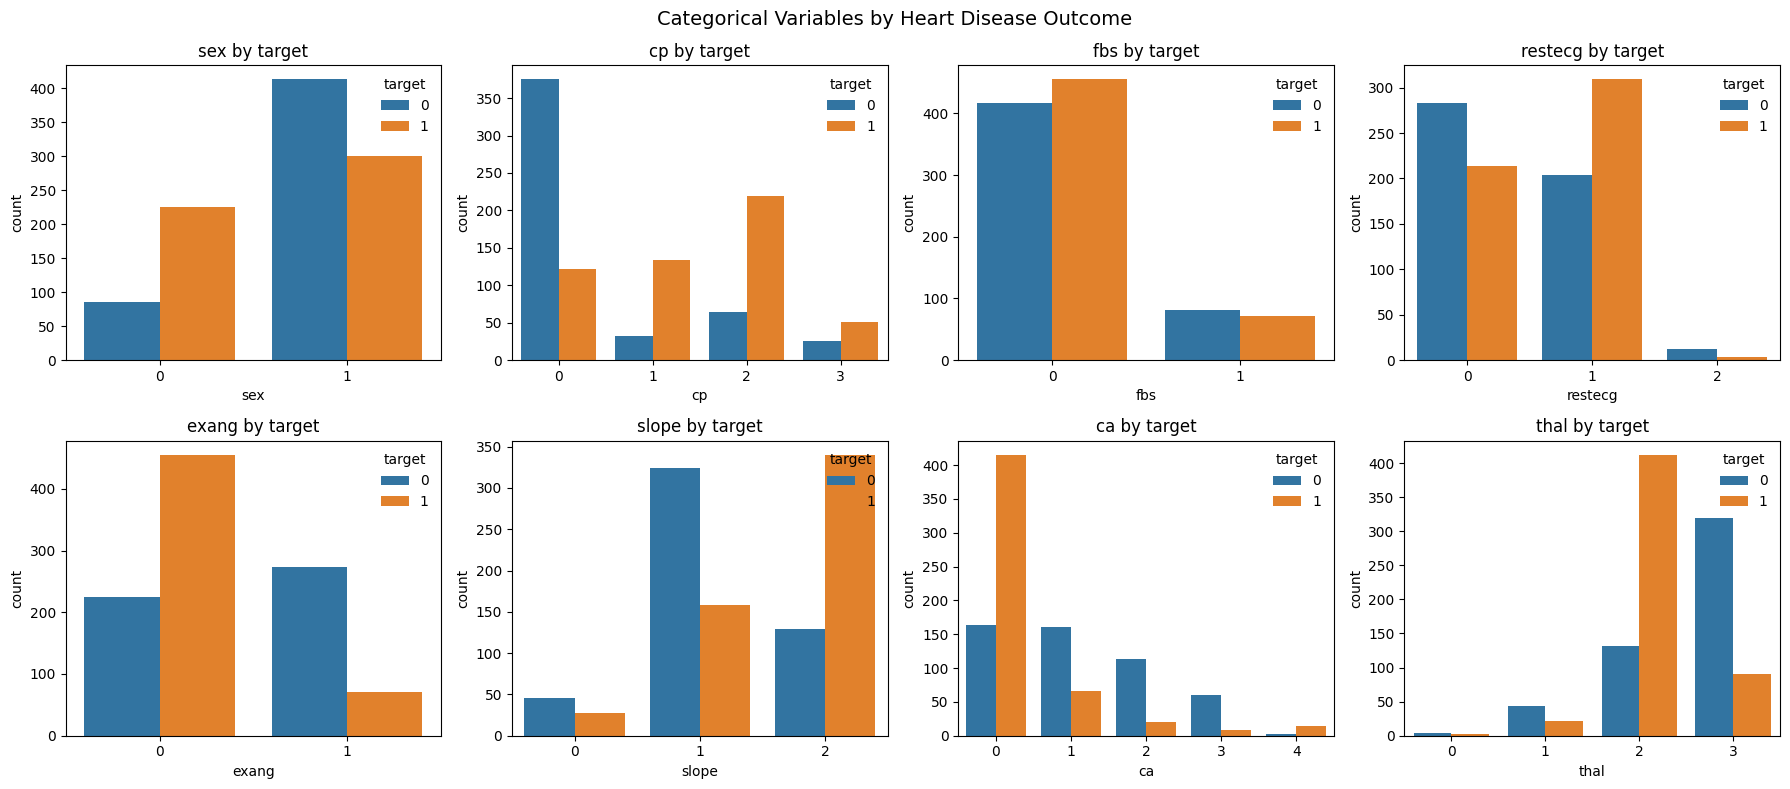

In [10]:
fig, axes = plt.subplots(2, 4, figsize=(18,8))
axes = axes.flatten()
for i, col in enumerate(cat_cols):
    sns.countplot(data=df, x=col, hue='target', ax=axes[i],
                  order=sorted(df[col].unique()))
    axes[i].set_title(f'{col} by target')
    axes[i].legend(title='target', loc='upper right', frameon=False)
    
plt.suptitle("Categorical Variables by Heart Disease Outcome", fontsize=14)
plt.tight_layout()
plt.show()

**Observations:**

- Female patients seem to have a higher propensity for heart disease

- Patients with heart disease are more likely to have chest pain type cp=1, cp=2, or cp=3, and abnormal thal=2 results.

- exang=0 (no exercise-induced angina) is also more frequent among those with disease, suggesting an inverse relationship.

- Weirdly enough, patients with ca=0 seem to have a much higher rate of heart disease. This could suggest that parents that have never had any major vessels colored are less health conscious and therefore have higher rates of heart disease

### Class Balance
Checking how many samples belong to each class helps identify whether the dataset is balanced.
A balanced target distribution ensures the model doesn’t favor one outcome

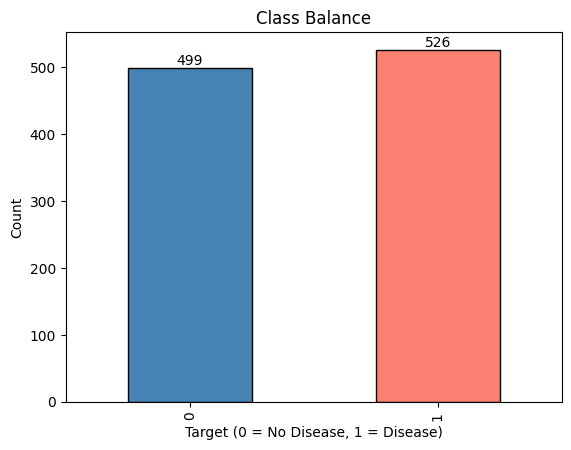

In [11]:
ax = df['target'].value_counts().sort_index().plot(
    kind='bar',
    color=['steelblue', 'salmon'],
    edgecolor='black'
)

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2, p.get_height()),
                ha='center', va='bottom', fontsize=10, color='black')

ax.set_xlabel('Target (0 = No Disease, 1 = Disease)')
ax.set_ylabel('Count')
ax.set_title('Class Balance')
plt.show()

### Summary of EDA Findings

- No missing values were found, but 723 duplicate rows were removed.
- The dataset includes 14 features (5 continuous, 8 categorical, and 1 target).
- Continuous variables (`chol`, `oldpeak`, `trestbps`) show mild right-skew and some outliers.
- Categorical variables (`cp`, `thal`, `exang`) show clear associations with heart disease.
- Correlation analysis highlights `thal_2`, `thal_3`, `exang_1`, and `cp_2` may serve as key predictive features.
- The dataset is sufficiently balanced between patients with and without disease.
- Scaling and encoding will be handled in the preprocessing stage.

## 4. Data Preprocessing

### Prepare features for modeling
We split the data with stratification, one-hot encode categorical features (drop one level to avoid multicollinearity), and scale continuous features. All transforms are fit on the training set only to prevent data leakage, then applied to the test set.

In [13]:
# Split features and target
X = df.drop('target', axis=1)
y = df['target']

# One-hot encode categorical variables
X = pd.get_dummies(X, columns=cat_cols, drop_first=True)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Scale continuous features
scaler = StandardScaler()
X_train[cont_cols] = scaler.fit_transform(X_train[cont_cols])
X_test[cont_cols] = scaler.transform(X_test[cont_cols])

# Confirm shapes
print("Train set shape:", X_train.shape)
print("Test set shape:", X_test.shape)
print("Encoded columns:", list(X_train.columns))
X_train.head()

Train set shape: (820, 22)
Test set shape: (205, 22)
Encoded columns: ['age', 'trestbps', 'chol', 'thalach', 'oldpeak', 'sex_1', 'cp_1', 'cp_2', 'cp_3', 'fbs_1', 'restecg_1', 'restecg_2', 'exang_1', 'slope_1', 'slope_2', 'ca_1', 'ca_2', 'ca_3', 'ca_4', 'thal_1', 'thal_2', 'thal_3']


,age,trestbps,chol,thalach,oldpeak,sex_1,cp_1,cp_2,cp_3,fbs_1,...,exang_1,slope_1,slope_2,ca_1,ca_2,ca_3,ca_4,thal_1,thal_2,thal_3
835,-0.585840,-0.779454,-1.935031,-1.019094,-0.210661,True,False,True,False,False,...,False,False,True,False,False,True,False,False,True,False
137,1.051477,2.741732,1.610634,0.202882,-0.912152,False,False,False,False,False,...,True,False,True,False,False,False,False,False,True,False
534,-0.040068,-1.347387,0.442176,0.770228,-0.912152,False,False,True,False,False,...,False,False,True,False,False,False,False,False,True,False
495,0.505705,0.186033,-0.222636,0.508376,-0.473720,True,False,False,False,False,...,False,True,False,False,False,False,False,False,False,True
244,-0.367531,-0.381900,-0.001032,0.726586,1.192321,True,False,True,False,True,...,False,True,False,False,False,False,False,False,True,False


### Preprocessing Summary

- The dataset was split into 80% training and 20% testing subsets to evaluate model performance on unseen data.  
- Categorical variables were *one-hot encoded* using `pd.get_dummies()`, converting each category into binary (0/1) columns.  
  - The `drop_first=True` parameter was used to avoid redundancy by removing one column per categorical feature.  
- Continuous features (`age`, `trestbps`, `chol`, `thalach`, `oldpeak`) were scaled using `StandardScaler` to ensure all values are on a comparable scale.  
- The final dataset is now fully numeric and scaled


## 5. Model Training

## 6. Evaluation

## 7. Discussion and Conclusion